In [1]:
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from pandas import set_option
import pandas as pd
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn 
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Dropout
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

import tensorflow as tf
import time as tm
import datetime
import os
from operator import itemgetter
from numpy import argmax

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Using InpactorDB with negative class

In [2]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

filename = '../InpactorDB/InpactorDB_non-redundant+negative.fasta.kmers'
training_data = pd.read_csv(filename)
filename=None

In [3]:
path_log_base = './logs'
# class dist|ribution
print(training_data.groupby('Label').size())

Label
0     34823
1     12031
3      1458
4      1827
8        84
9      3556
12     6180
13     3130
14     2136
16      549
17     4532
18    10396
19     3499
20    17927
dtype: int64


In [4]:
label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values

training_data=None

label_vectors
feature_vectors

array([[2592, 1965, 1269, ...,    4,    0,    0],
       [2959, 2249, 1811, ...,    0,    0,    0],
       [5673, 3949, 3563, ...,    8,    4,    3],
       ...,
       [1451, 1264, 1601, ...,    1,    4,    4],
       [2242, 1036, 1271, ...,    7,   12,   28],
       [2585, 1395, 1287, ...,    5,    6,    7]])

In [5]:
# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)

#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_trainScaler, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                        random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)
feature_vectors=None
label_vectors=None


In [6]:
pca = decomposition.PCA(n_components=0.96 ,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

In [7]:
print(len(X_trainPCAScaler[0]))
print(X_trainPCAScaler.shape)

2287
(81702, 2287)


In [8]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [31]:
def metrics(Y_validation,predictions):
    classes = len(np.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [10]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation F1-Score {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('F1-Score Vs Epoch')
        plt.ylabel('F1-Score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [11]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_testPCAScaler, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [12]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [13]:
def Nakano_Net():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    #Inputs
    inputs = tf.keras.Input(shape=(X_trainPCAScaler.shape[1],), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(200,activation="relu")(inputs)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #layer 2
    layers = tf.keras.layers.Dense(200,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #layer 3
    layers = tf.keras.layers.Dense(200,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    # layer 4
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['f1_m'])
    return model

In [14]:
def InpactorFNN_Net():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    #Inputs
    inputs = tf.keras.Input(shape=(X_trainPCAScaler.shape[1],), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(inputs)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 2
    layers = tf.keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 3
    layers = tf.keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 4
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=[f1_m])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2287)]            0         
_________________________________________________________________
dense (Dense)                (None, 200)               457600    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               600   

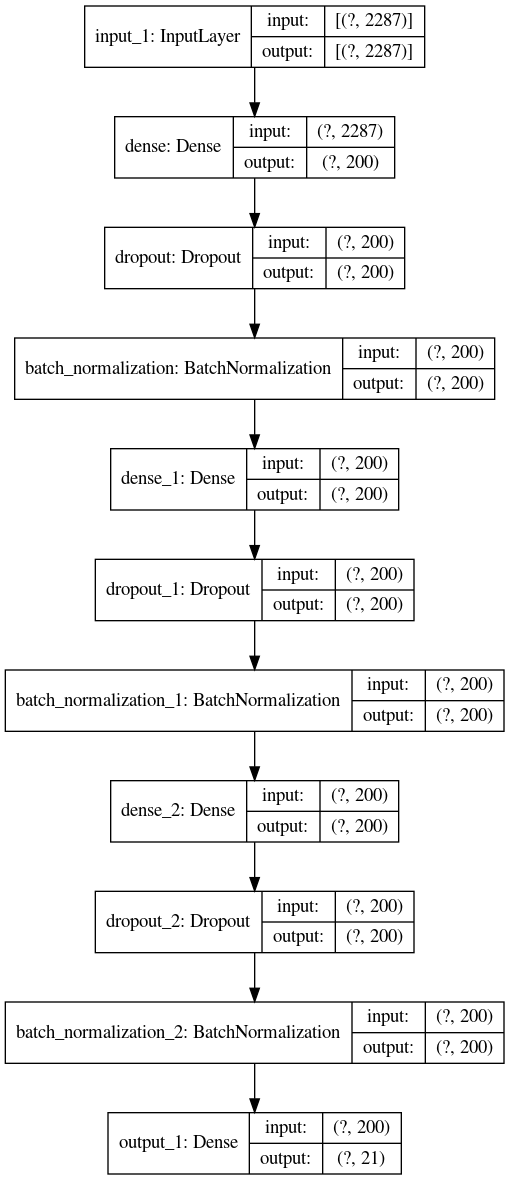

In [15]:
# linea base, arquitectura de Nakano
# model = InpactorFNN_Net()

# arquitectura a afinar
model = InpactorFNN_Net()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
one_hot_labels_train = tf.keras.utils.to_categorical(Y_trainScaler, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 200, "Nakano1")
Final_Results_Test(log_Dir) 

Epoch 1/200
639/639 [==============================] - 3s 4ms/step - loss: 2.1843 - f1_m: 0.7383 - val_loss: 1.2344 - val_f1_m: 0.9552
Epoch 2/200
639/639 [==============================] - 3s 4ms/step - loss: 1.2025 - f1_m: 0.9164 - val_loss: 0.9649 - val_f1_m: 0.9647
Epoch 3/200
639/639 [==============================] - 3s 4ms/step - loss: 1.0104 - f1_m: 0.9345 - val_loss: 0.8692 - val_f1_m: 0.9670
Epoch 4/200
639/639 [==============================] - 3s 4ms/step - loss: 0.9394 - f1_m: 0.9401 - val_loss: 0.8311 - val_f1_m: 0.9691
Epoch 5/200
639/639 [==============================] - 3s 4ms/step - loss: 0.9242 - f1_m: 0.9410 - val_loss: 0.8335 - val_f1_m: 0.9712
Epoch 6/200
639/639 [==============================] - 3s 4ms/step - loss: 0.9058 - f1_m: 0.9424 - val_loss: 0.8030 - val_f1_m: 0.9715
Epoch 7/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8953 - f1_m: 0.9444 - val_loss: 0.8071 - val_f1_m: 0.9708
Epoch 8/200
639/639 [==============================] - 

639/639 [==============================] - 3s 4ms/step - loss: 0.8806 - f1_m: 0.9507 - val_loss: 0.8156 - val_f1_m: 0.9729
Epoch 62/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8726 - f1_m: 0.9518 - val_loss: 0.8138 - val_f1_m: 0.9720
Epoch 63/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8779 - f1_m: 0.9511 - val_loss: 0.7992 - val_f1_m: 0.9725
Epoch 64/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8664 - f1_m: 0.9516 - val_loss: 0.7995 - val_f1_m: 0.9732
Epoch 65/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8762 - f1_m: 0.9504 - val_loss: 0.7968 - val_f1_m: 0.9738
Epoch 66/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8747 - f1_m: 0.9512 - val_loss: 0.7949 - val_f1_m: 0.9743
Epoch 67/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8728 - f1_m: 0.9510 - val_loss: 0.8089 - val_f1_m: 0.9734
Epoch 68/200
639/639 [==============================] - 3s 4m

639/639 [==============================] - 3s 4ms/step - loss: 0.8801 - f1_m: 0.9512 - val_loss: 0.8004 - val_f1_m: 0.9732
Epoch 122/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8710 - f1_m: 0.9511 - val_loss: 0.8117 - val_f1_m: 0.9731
Epoch 123/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8655 - f1_m: 0.9518 - val_loss: 0.8056 - val_f1_m: 0.9737
Epoch 124/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8807 - f1_m: 0.9516 - val_loss: 0.8010 - val_f1_m: 0.9727
Epoch 125/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8662 - f1_m: 0.9519 - val_loss: 0.7958 - val_f1_m: 0.9731
Epoch 126/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8796 - f1_m: 0.9509 - val_loss: 0.8095 - val_f1_m: 0.9708
Epoch 127/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8657 - f1_m: 0.9519 - val_loss: 0.7893 - val_f1_m: 0.9750
Epoch 128/200
639/639 [==============================] 

Epoch 181/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8692 - f1_m: 0.9521 - val_loss: 0.7904 - val_f1_m: 0.9726
Epoch 182/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8692 - f1_m: 0.9514 - val_loss: 0.8049 - val_f1_m: 0.9743
Epoch 183/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8620 - f1_m: 0.9529 - val_loss: 0.8056 - val_f1_m: 0.9730
Epoch 184/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8662 - f1_m: 0.9517 - val_loss: 0.7880 - val_f1_m: 0.9725
Epoch 185/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8704 - f1_m: 0.9517 - val_loss: 0.8130 - val_f1_m: 0.9730
Epoch 186/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8576 - f1_m: 0.9525 - val_loss: 0.7829 - val_f1_m: 0.9727
Epoch 187/200
639/639 [==============================] - 3s 4ms/step - loss: 0.8635 - f1_m: 0.9518 - val_loss: 0.8012 - val_f1_m: 0.9743
Epoch 188/200
639/639 [==================

Loss=0.8057 y F1-Score=0.9699

saved-model-093-0.9720.hdf5
Loss=0.8066 y F1-Score=0.9692

saved-model-094-0.9730.hdf5
Loss=0.8107 y F1-Score=0.9715

saved-model-095-0.9726.hdf5
Loss=0.8202 y F1-Score=0.9689

saved-model-096-0.9744.hdf5
Loss=0.8082 y F1-Score=0.9725

saved-model-097-0.9721.hdf5
Loss=0.8098 y F1-Score=0.9697

saved-model-098-0.9746.hdf5
Loss=0.8062 y F1-Score=0.9708

saved-model-099-0.9708.hdf5
Loss=0.8038 y F1-Score=0.9688

saved-model-100-0.9737.hdf5
Loss=0.8183 y F1-Score=0.9707

saved-model-101-0.9742.hdf5
Loss=0.8014 y F1-Score=0.9716

saved-model-102-0.9717.hdf5
Loss=0.8060 y F1-Score=0.9708

saved-model-103-0.9737.hdf5
Loss=0.8029 y F1-Score=0.9714

saved-model-104-0.9740.hdf5
Loss=0.8095 y F1-Score=0.9713

saved-model-105-0.9742.hdf5
Loss=0.8027 y F1-Score=0.9700

saved-model-106-0.9742.hdf5
Loss=0.7966 y F1-Score=0.9706

saved-model-107-0.9734.hdf5
Loss=0.8145 y F1-Score=0.9713

saved-model-108-0.9742.hdf5
Loss=0.7903 y F1-Score=0.9722

saved-model-109-0.9741.hd

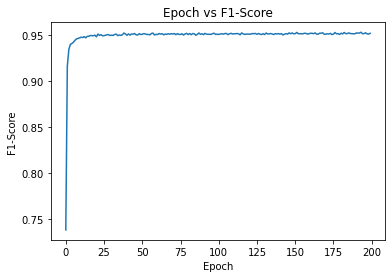

Test Accuracy 0.9739893078804016, Época:163

Test Accuracy 0.9730420112609863, Época:149

Test Accuracy 0.9729673266410828, Época:60

Test Accuracy 0.9727008938789368, Época:27

Test Accuracy 0.9725865125656128, Época:154

Test Accuracy 0.9725039601325989, Época:192

Test Accuracy 0.9724773168563843, Época:96

Test Accuracy 0.9723812341690063, Época:74

Test Accuracy 0.9722593426704407, Época:80

Test Accuracy 0.9722258448600769, Época:108


Train Accuracy 0.95321124792099, Época:194

Train Accuracy 0.9529997706413269, Época:152

Train Accuracy 0.9529498219490051, Época:183

Train Accuracy 0.9529125690460205, Época:177

Train Accuracy 0.9526172280311584, Época:197

Train Accuracy 0.9525774717330933, Época:169

Train Accuracy 0.9525160789489746, Época:186

Train Accuracy 0.95249342918396, Época:191

Train Accuracy 0.9524844884872437, Época:116

Train Accuracy 0.952483594417572, Época:147


Validation F1-Score 0.9752645492553711, Época:196

Validation F1-Score 0.9751016497612, Época:114


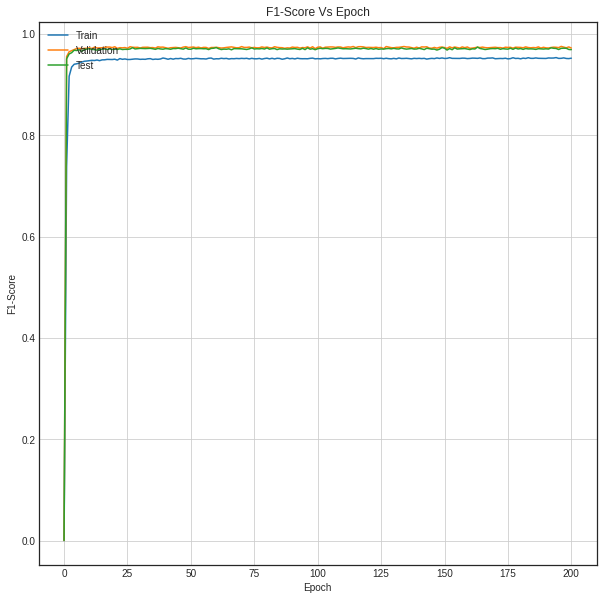

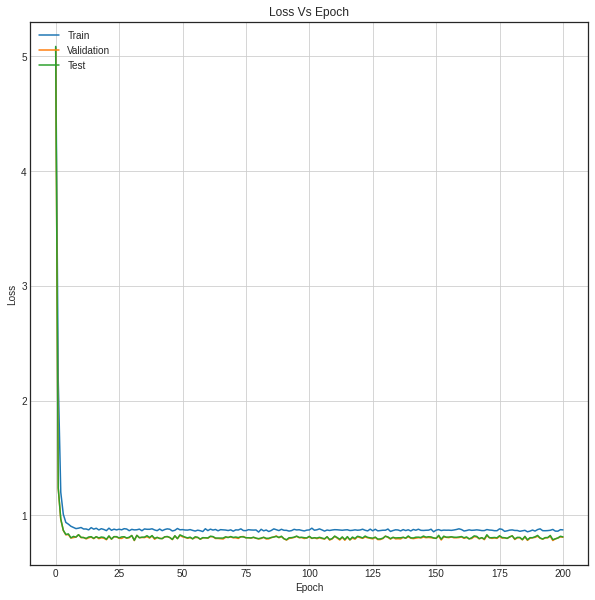

In [17]:
# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

Baseline Error train: 1.92%
Baseline Error dev: 2.79%
Baseline Error test: 3.11%
Accuracy: 0.9807715845389342
F1 score: 0.9803660554721954
Recall: 0.9807715845389342
Precision: 0.9803912388178185


/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     27905
           1       0.99      0.99      0.99      9583
           3       0.97      0.99      0.98      1204
           4       1.00      1.00      1.00      1466
           8       0.00      0.00      0.00        68
           9       0.99      0.98      0.98      2844
          12       0.97      0.98      0.98      4943
          13       0.95      1.00      0.97      2502
          14       0.97      0.98      0.98      1708
          16       0.98      0.97      0.98       432
          17       0.98      1.00      0.99      3577
          18       0.98      0.99      0.98      8258
          19       0.98      0.99      0.98      2821
          20       0.96      1.00      0.98     14391

    accuracy                           0.98     81702
   macro avg       0.91      0.92      0.91     81702
weighted avg       0.98      0.98      0.98     81702



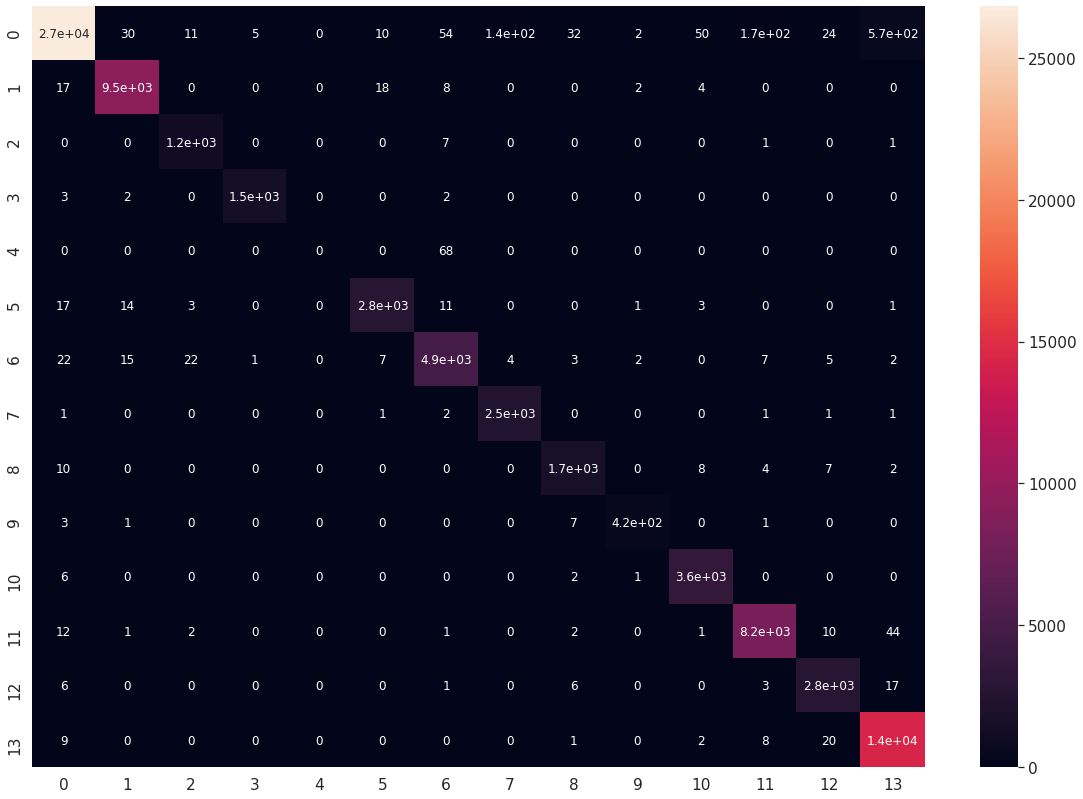

Accuracy: 0.971898560657985
F1 score: 0.9716021606714754
Recall: 0.971898560657985
Precision: 0.9719220916233007

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      3458
           1       0.98      0.98      0.98      1244
           3       0.92      0.98      0.95       122
           4       0.99      0.98      0.99       188
           8       0.00      0.00      0.00         7
           9       0.98      0.97      0.97       369
          12       0.95      0.96      0.96       616
          13       0.93      0.97      0.95       317
          14       0.95      0.95      0.95       216
          16       0.98      0.94      0.96        51
          17       0.96      0.99      0.98       485
          18       0.97      0.98      0.98      1069
          19       0.98      0.97      0.97       330
          20       0.94      1.00      0.97      1741

    accuracy                           0.97     10

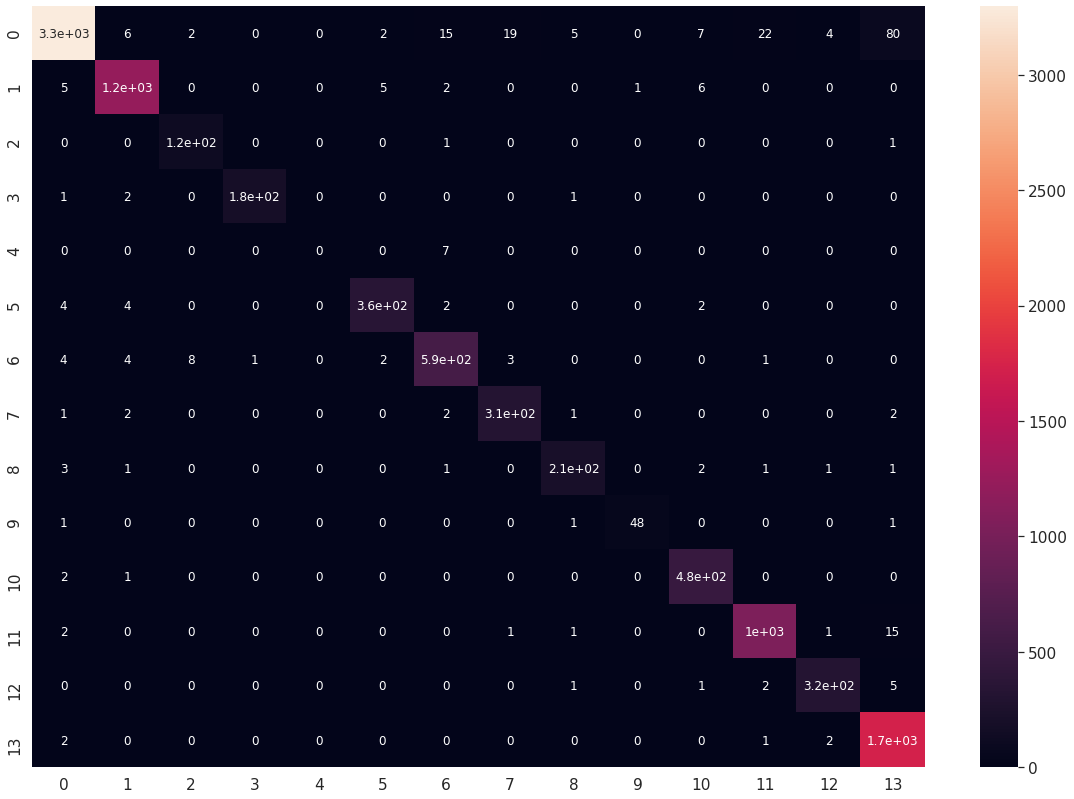

Accuracy: 0.9686673847057672
F1 score: 0.9682723143480985
Recall: 0.9686673847057672
Precision: 0.968522421031561

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      3460
           1       0.99      0.99      0.99      1204
           3       0.96      0.98      0.97       132
           4       1.00      0.98      0.99       173
           8       0.00      0.00      0.00         9
           9       0.95      0.96      0.95       343
          12       0.95      0.96      0.95       621
          13       0.90      0.99      0.94       311
          14       0.95      0.92      0.94       212
          16       0.94      0.92      0.93        66
          17       0.98      0.99      0.99       470
          18       0.96      0.99      0.97      1069
          19       0.95      0.97      0.96       348
          20       0.95      0.99      0.97      1795

    accuracy                           0.97     1

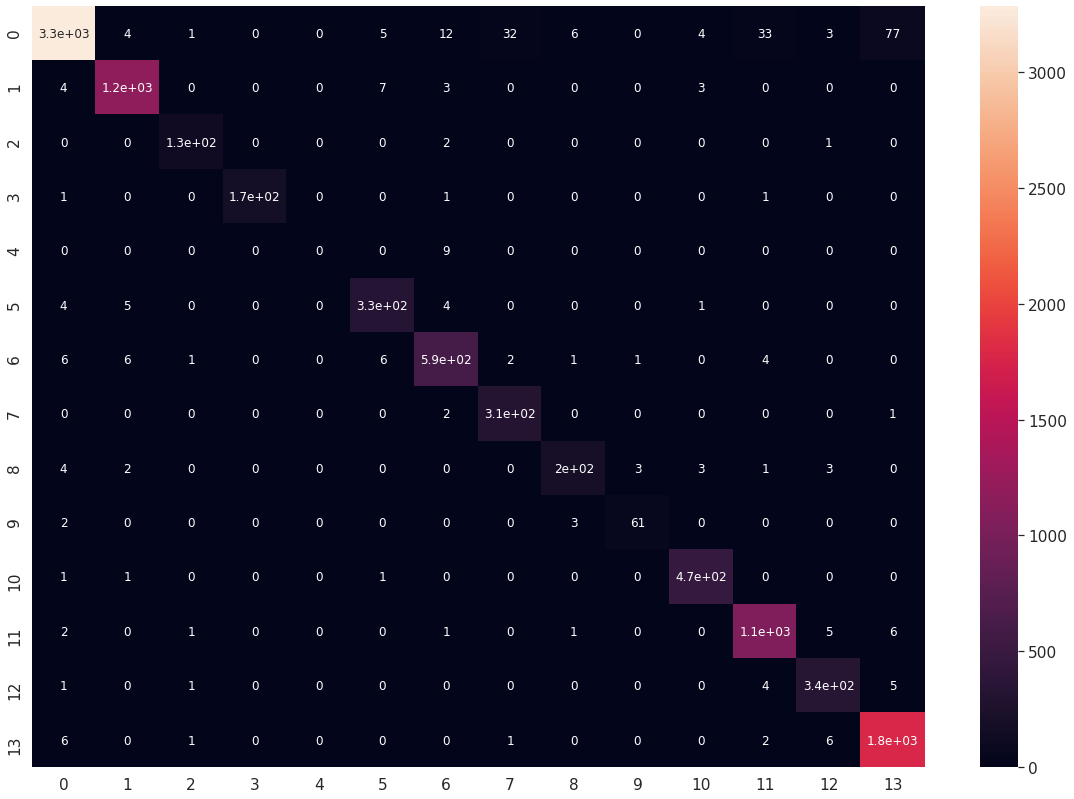

In [18]:
scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_trainScaler, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

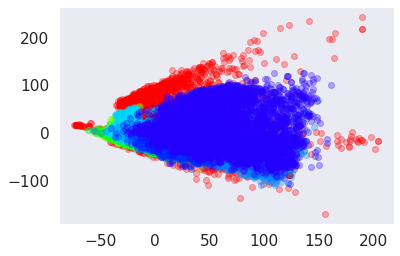

In [19]:
import mlutils
mlutils.plot_2Ddata(np.array([X_trainPCAScaler[:, 0], X_trainPCAScaler[:, 1]]).transpose(), Y_trainScaler, dots_alpha=.3)
plt.grid()

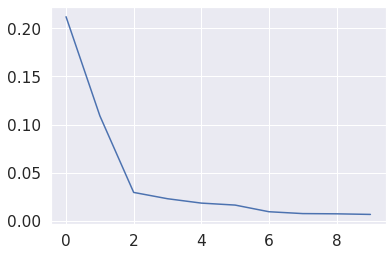

In [85]:
plt.plot(pca.explained_variance_ratio_[0:10])

# Using InpactorDB without negative class

In [20]:
filename = '/home/bioml/Projects/PhD/InpactorDB/version_final/InpactorDB_non-redudant.fasta.kmers'
training_data = pd.read_csv(filename)
filename=None

label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values

training_data=None

label_vectors
feature_vectors

array([[2592, 1965, 1269, ...,    4,    0,    0],
       [2959, 2249, 1811, ...,    0,    0,    0],
       [5673, 3949, 3563, ...,    8,    4,    3],
       ...,
       [1939,  906, 1146, ...,    4,    8,    6],
       [3071, 1904, 1979, ...,    4,    1,    1],
       [1422,  696, 1208, ...,    1,    1,    1]])

In [21]:
# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)

#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_trainScaler, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                        random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)
feature_vectors=None
label_vectors=None

In [22]:
pca = decomposition.PCA(n_components=0.96 ,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

print(len(X_trainPCAScaler[0]))
print(X_trainPCAScaler.shape)

2261
(53844, 2261)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2261)]            0         
_________________________________________________________________
dense (Dense)                (None, 200)               452400    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               600   

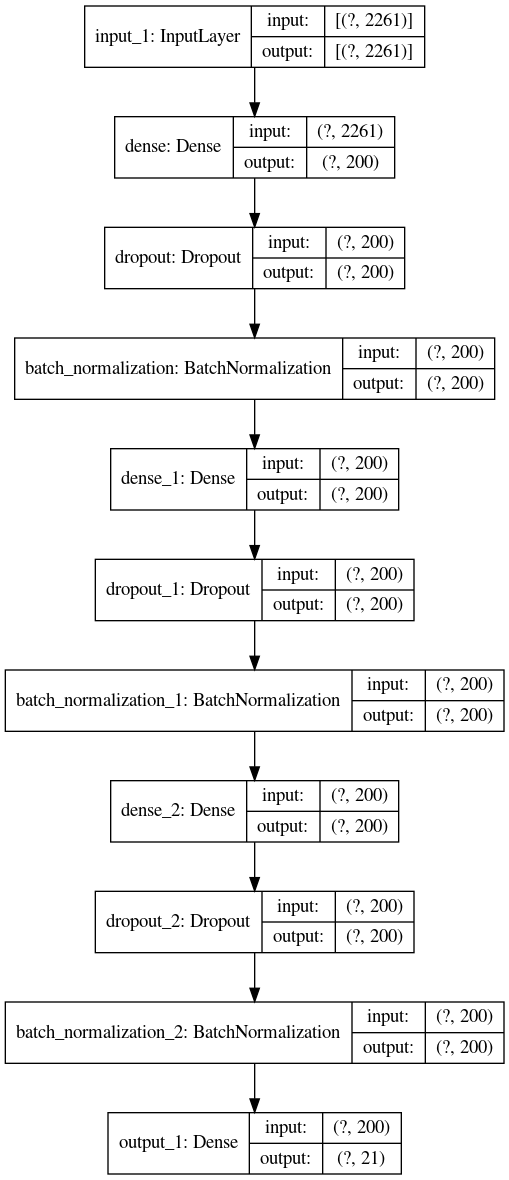

In [23]:
# arquitectura a afinar
model = InpactorFNN_Net()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
one_hot_labels_train = tf.keras.utils.to_categorical(Y_trainScaler, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 200, "Nakano1")
Final_Results_Test(log_Dir) 

Epoch 1/200
421/421 [==============================] - 4s 10ms/step - loss: 2.3103 - f1_m: 0.7036 - val_loss: 1.3015 - val_f1_m: 0.9606
Epoch 2/200
421/421 [==============================] - 2s 4ms/step - loss: 1.2328 - f1_m: 0.9291 - val_loss: 0.9766 - val_f1_m: 0.9744
Epoch 3/200
421/421 [==============================] - 2s 4ms/step - loss: 0.9828 - f1_m: 0.9505 - val_loss: 0.8528 - val_f1_m: 0.9784
Epoch 4/200
421/421 [==============================] - 2s 4ms/step - loss: 0.8919 - f1_m: 0.9559 - val_loss: 0.7986 - val_f1_m: 0.9788
Epoch 5/200
421/421 [==============================] - 2s 4ms/step - loss: 0.8302 - f1_m: 0.9605 - val_loss: 0.7586 - val_f1_m: 0.9805
Epoch 6/200
421/421 [==============================] - 2s 4ms/step - loss: 0.8210 - f1_m: 0.9606 - val_loss: 0.7453 - val_f1_m: 0.9820
Epoch 7/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7991 - f1_m: 0.9619 - val_loss: 0.7569 - val_f1_m: 0.9793
Epoch 8/200
421/421 [==============================] -

Epoch 60/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7699 - f1_m: 0.9703 - val_loss: 0.7311 - val_f1_m: 0.9836
Epoch 61/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7691 - f1_m: 0.9703 - val_loss: 0.7319 - val_f1_m: 0.9833
Epoch 62/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7636 - f1_m: 0.9702 - val_loss: 0.7116 - val_f1_m: 0.9850
Epoch 63/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7663 - f1_m: 0.9698 - val_loss: 0.7271 - val_f1_m: 0.9839
Epoch 64/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7615 - f1_m: 0.9701 - val_loss: 0.7372 - val_f1_m: 0.9850
Epoch 65/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7708 - f1_m: 0.9698 - val_loss: 0.7439 - val_f1_m: 0.9835
Epoch 66/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7751 - f1_m: 0.9695 - val_loss: 0.7166 - val_f1_m: 0.9857
Epoch 67/200
421/421 [==========================

421/421 [==============================] - 2s 4ms/step - loss: 0.7635 - f1_m: 0.9707 - val_loss: 0.7279 - val_f1_m: 0.9834
Epoch 121/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7588 - f1_m: 0.9718 - val_loss: 0.7365 - val_f1_m: 0.9839
Epoch 122/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7651 - f1_m: 0.9717 - val_loss: 0.7203 - val_f1_m: 0.9844
Epoch 123/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7718 - f1_m: 0.9695 - val_loss: 0.7434 - val_f1_m: 0.9848
Epoch 124/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7637 - f1_m: 0.9710 - val_loss: 0.7299 - val_f1_m: 0.9845
Epoch 125/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7662 - f1_m: 0.9718 - val_loss: 0.7331 - val_f1_m: 0.9846
Epoch 126/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7772 - f1_m: 0.9703 - val_loss: 0.7306 - val_f1_m: 0.9857
Epoch 127/200
421/421 [==============================] 

Epoch 180/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7784 - f1_m: 0.9694 - val_loss: 0.7466 - val_f1_m: 0.9842
Epoch 181/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7595 - f1_m: 0.9716 - val_loss: 0.7250 - val_f1_m: 0.9860
Epoch 182/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7751 - f1_m: 0.9696 - val_loss: 0.7354 - val_f1_m: 0.9848
Epoch 183/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7689 - f1_m: 0.9708 - val_loss: 0.7146 - val_f1_m: 0.9842
Epoch 184/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7560 - f1_m: 0.9721 - val_loss: 0.7372 - val_f1_m: 0.9857
Epoch 185/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7697 - f1_m: 0.9704 - val_loss: 0.7196 - val_f1_m: 0.9853
Epoch 186/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7710 - f1_m: 0.9705 - val_loss: 0.7379 - val_f1_m: 0.9852
Epoch 187/200
421/421 [==================

Loss=0.7287 y F1-Score=0.9851

saved-model-091-0.9850.hdf5
Loss=0.7239 y F1-Score=0.9864

saved-model-092-0.9860.hdf5
Loss=0.7097 y F1-Score=0.9868

saved-model-093-0.9856.hdf5
Loss=0.7269 y F1-Score=0.9855

saved-model-094-0.9859.hdf5
Loss=0.7071 y F1-Score=0.9874

saved-model-095-0.9849.hdf5
Loss=0.7318 y F1-Score=0.9860

saved-model-096-0.9808.hdf5
Loss=0.7227 y F1-Score=0.9850

saved-model-097-0.9858.hdf5
Loss=0.7319 y F1-Score=0.9851

saved-model-098-0.9828.hdf5
Loss=0.7319 y F1-Score=0.9865

saved-model-099-0.9850.hdf5
Loss=0.7144 y F1-Score=0.9862

saved-model-100-0.9847.hdf5
Loss=0.7095 y F1-Score=0.9852

saved-model-101-0.9852.hdf5
Loss=0.7113 y F1-Score=0.9858

saved-model-102-0.9857.hdf5
Loss=0.7126 y F1-Score=0.9853

saved-model-103-0.9846.hdf5
Loss=0.6969 y F1-Score=0.9869

saved-model-104-0.9851.hdf5
Loss=0.7188 y F1-Score=0.9856

saved-model-105-0.9853.hdf5
Loss=0.7229 y F1-Score=0.9858

saved-model-106-0.9847.hdf5
Loss=0.7257 y F1-Score=0.9854

saved-model-107-0.9848.hd

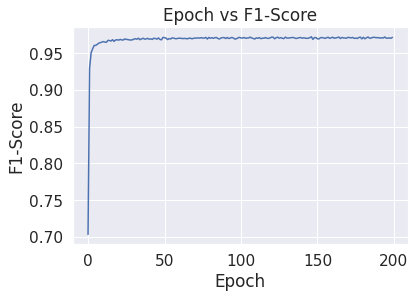

Test Accuracy 0.9881845116615295, Época:126

Test Accuracy 0.9881609082221985, Época:72

Test Accuracy 0.9881560802459717, Época:197

Test Accuracy 0.9878860116004944, Época:182

Test Accuracy 0.9878742098808289, Época:148

Test Accuracy 0.9877988696098328, Época:49

Test Accuracy 0.9877210855484009, Época:114

Test Accuracy 0.9876506924629211, Época:66

Test Accuracy 0.9874439835548401, Época:175

Test Accuracy 0.9874322414398193, Época:94


Train Accuracy 0.972334086894989, Época:147

Train Accuracy 0.9720553755760193, Época:184

Train Accuracy 0.9719725251197815, Época:195

Train Accuracy 0.9718947410583496, Época:165

Train Accuracy 0.971821665763855, Época:130

Train Accuracy 0.9718118906021118, Época:107

Train Accuracy 0.9717857241630554, Época:125

Train Accuracy 0.9717831015586853, Época:179

Train Accuracy 0.9717777371406555, Época:121

Train Accuracy 0.971714973449707, Época:122


Validation F1-Score 0.9867386817932129, Época:73

Validation F1-Score 0.9864062070846558, Época

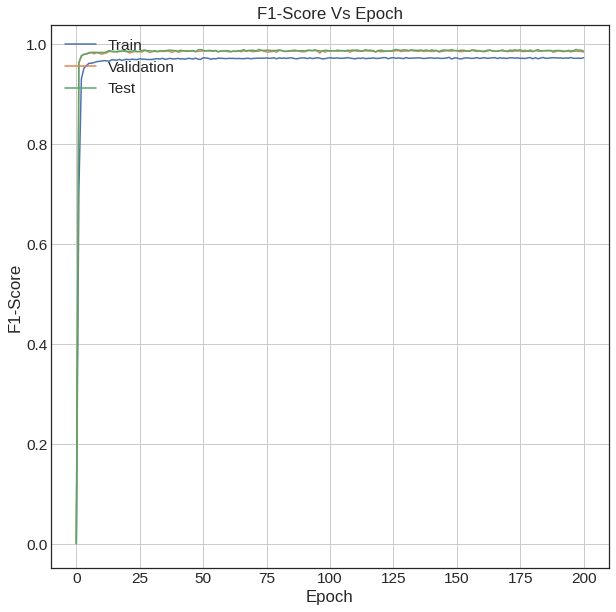

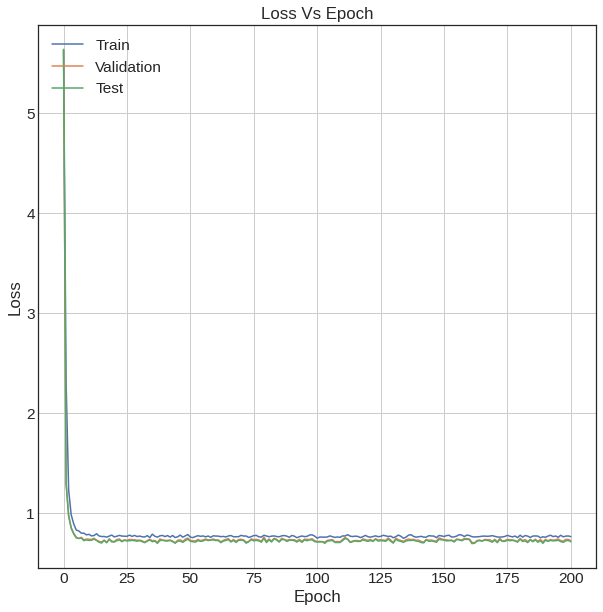

In [25]:
# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

Baseline Error train: 0.58%
Baseline Error dev: 1.73%
Baseline Error test: 1.51%
Accuracy: 0.9941311938191814
F1 score: 0.9934771487363415
Recall: 0.9941311938191814
Precision: 0.9928334552781335

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      9563
           3       0.98      0.99      0.99      1158
           4       1.00      1.00      1.00      1481
           8       0.00      0.00      0.00        71
           9       0.99      0.99      0.99      2896
          12       0.98      0.99      0.99      5006
          13       1.00      1.00      1.00      2465
          14       0.99      0.99      0.99      1717
          16       1.00      0.99      1.00       434
          17       1.00      1.00      1.00      3605
          18       1.00      0.99      0.99      8282
          19       0.99      1.00      0.99      2765
          20       0.99      1.00      1.00     14401

    accuracy         

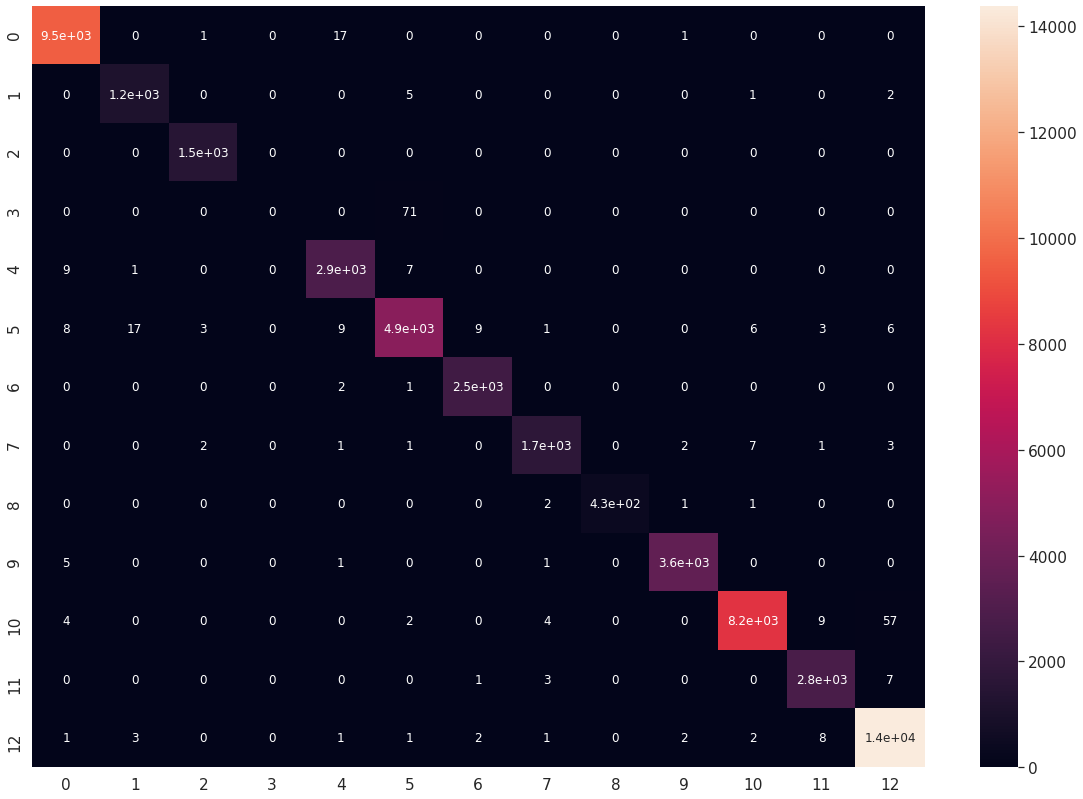

Accuracy: 0.9818722139673105
F1 score: 0.9814034220322148
Recall: 0.9818722139673105
Precision: 0.9810424708749693

 clasification report:
               precision    recall  f1-score   support

           1       0.98      0.99      0.99      1248
           3       0.96      0.99      0.97       155
           4       1.00      0.99      1.00       180
           8       0.00      0.00      0.00         6
           9       0.95      0.99      0.97       341
          12       0.98      0.95      0.97       599
          13       0.99      1.00      0.99       340
          14       0.97      0.95      0.96       218
          16       0.94      0.88      0.91        57
          17       0.98      0.99      0.98       430
          18       0.99      0.98      0.98      1055
          19       0.96      0.97      0.96       362
          20       0.99      0.99      0.99      1739

    accuracy                           0.98      6730
   macro avg       0.90      0.90      0.90     

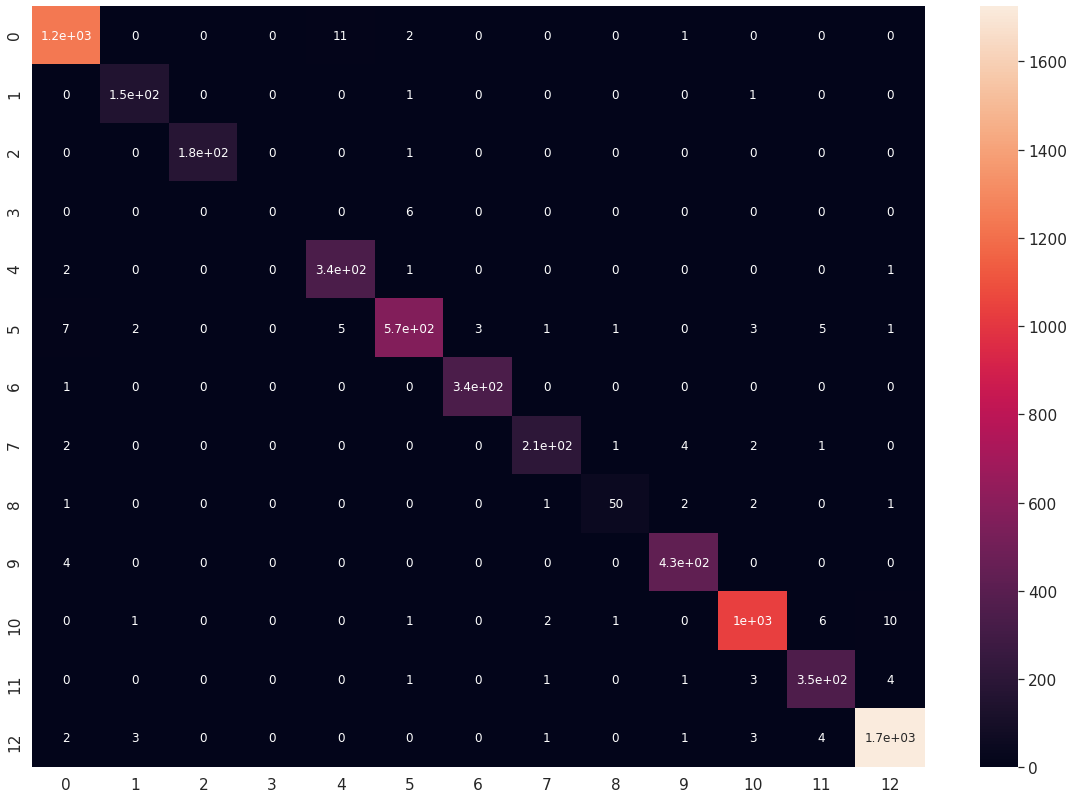

Accuracy: 0.9838062694993315
F1 score: 0.9833040627704511
Recall: 0.9838062694993315
Precision: 0.9828886091323733

 clasification report:
               precision    recall  f1-score   support

           1       0.99      0.99      0.99      1220
           3       0.95      0.97      0.96       145
           4       0.99      0.98      0.99       166
           8       0.00      0.00      0.00         7
           9       0.94      0.98      0.96       319
          12       0.97      0.95      0.96       575
          13       1.00      0.99      0.99       325
          14       0.96      0.96      0.96       201
          16       0.98      0.93      0.96        58
          17       0.99      0.99      0.99       497
          18       0.99      0.99      0.99      1059
          19       0.97      0.99      0.98       372
          20       0.99      0.99      0.99      1787

    accuracy                           0.98      6731
   macro avg       0.90      0.90      0.90     

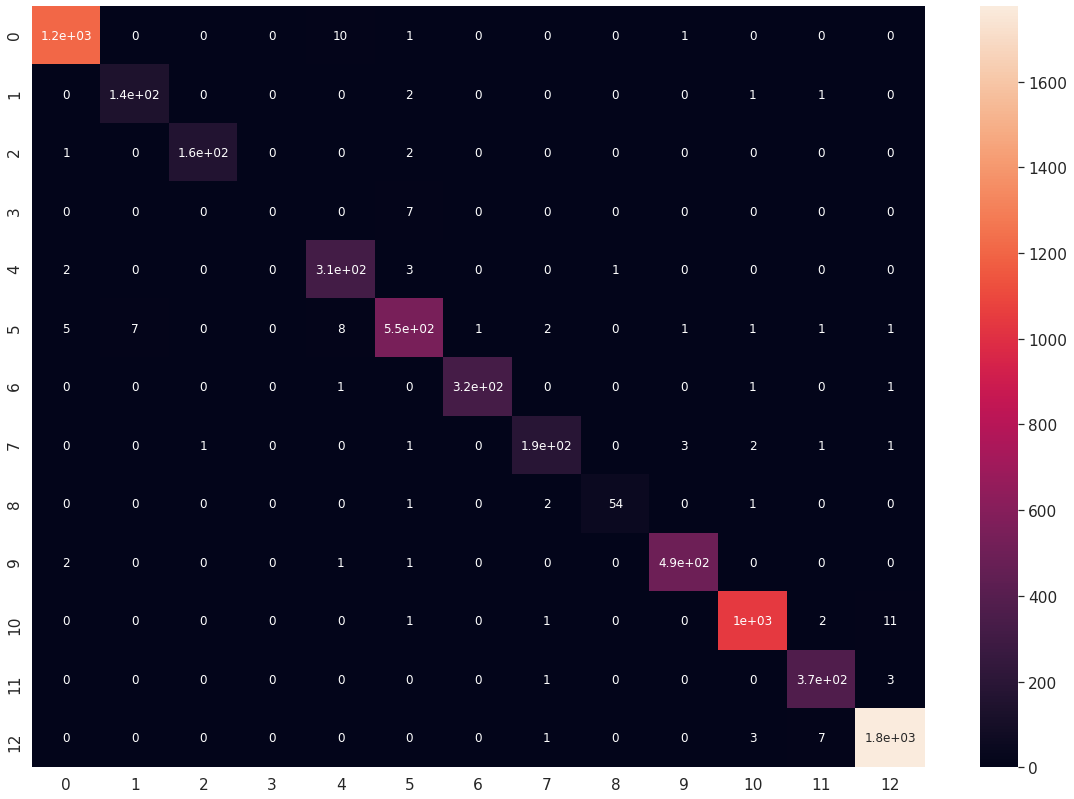

In [32]:
scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_trainScaler, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])